# POCKET: PriOritizing the Candidate genes by incorporating information of Knowledge-based gene sets, Effects of variants, GWAS (genome-wide association studies) and TWAS (transcriptome-wide association studies)

Based on multi-omic datasets in B. napus and functional gene sets identified in Arabidopsis, we developed an integrative framework which named POCKET (PriOritizing the Candidate genes by incorporating information of Knowledge-based gene sets, Effects of variants, GWAS and TWAS) to prioritize the candidate genes in SOC-related QTLs in B. napus. This framework incorporates the score of variations affecting protein function, the score of gene expression associated with the phenotype, and the score of gene function predicted by underlying connectivity with genes of certain functional gene sets. The framework integrates biological data, such as GO category, InterPro protein classification, DEGs of known SOC-related mutants or overexpression lines, ICA ccomponents identified from population transcriptome and utilizes machine learning methods to assess the possibility of each gene in a QTL region related to seed genes (the genes in functional gene sets identified from enrichment analysis using population transcriptome data). 

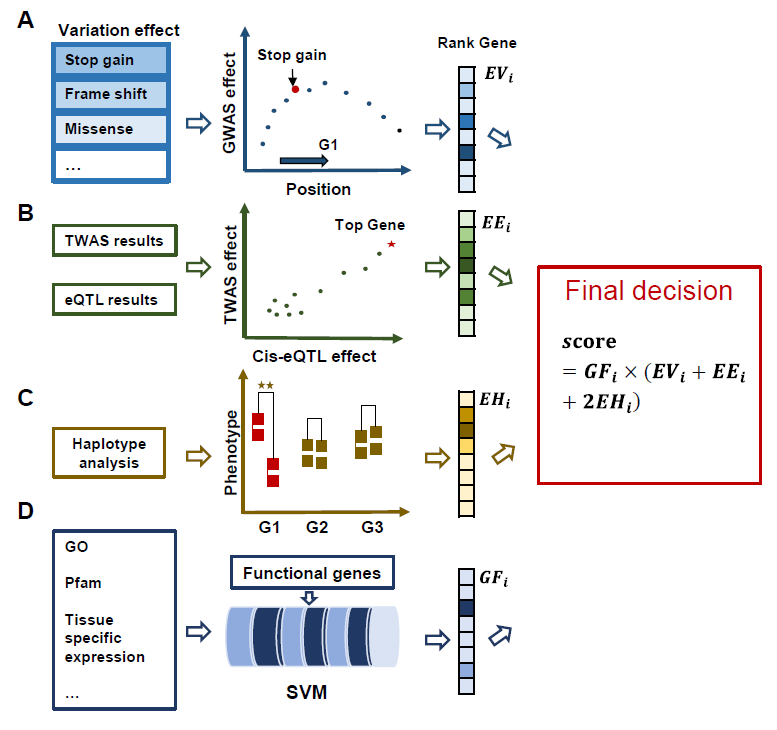

(A) Annotation of genomic variations. Score the genes with variation effect and variation P-value in GWAS. (B) Score the genes based on TWAS P-values and cis-eQTL P-values. (C) Identify the haplotypes of each gene and perform haplotype-based association analysis. (D) Collection of features (such as GO, Pfam and Tissue specific expression gene sets) and predict the gene function using SVM.

# 1. Import POCKET

In [21]:
import pandas as pd
from pocket import pocket

# 2. Data Preparing

The input you bring to the POCKET is:
1. GWAS results (The columns of the dataframe should include 'SNP', 'Chr', 'ChrPos' and 'Pvalue').
2. Variation annotation results (The columns of the dataframe should include 'SNP', 'Gene', 'Var_chrom', 'Var_pos' and 'Imapct').
3. Kinship matrix.
4. Phenotype results (The columns of the dataframe should include 'pheno').
5. Gene annotation results (The columns of the dataframe should include 'chrom', 'start', 'end', 'symbol' and 'description').
6. Positive traning sets of SVM.
7. Features used in SVM.
8. Expression matrix (optional).
9. TWAS results (optional).

## 2.1 GWAS results

In [5]:
gwas_df = pd.read_csv('./gwas_df_lmm_blup_All.gz',compression='gzip',sep='\t')
gwas_df.head()

sid_index              SNP     Chr  GenDist    ChrPos        PValue  \
0     427112  BnvaA0520328034  chrA05        0  20328034  6.443995e-13   
1     427111  BnvaA0520328033  chrA05        0  20328033  1.095793e-12   
2     427139  BnvaA0520328176  chrA05        0  20328176  1.884423e-12   
3     427174  BnvaA0520328897  chrA05        0  20328897  2.660958e-12   
4     427140  BnvaA0520328221  chrA05        0  20328221  3.273623e-12   

   SnpWeight  SnpWeightSE  SnpFractVarExpl  Mixing    Nullh2  
0  -0.867201     0.117130         0.327581     0.0  0.776803  
1  -0.848850     0.115892         0.324445     0.0  0.776803  
2  -0.866143     0.119586         0.321205     0.0  0.776803  
3  -0.844839     0.117493         0.319122     0.0  0.776803  
4  -0.851468     0.118937         0.317863     0.0  0.776803

## 2.2 Variation annotation results

In [7]:
effect_anno = pd.read_csv('./variations_annotation_SNPEff_results.csv.gz',compression='gzip',index_col=0)
effect_anno.loc[:,'SNP'] = effect_anno.index
effect_anno.head()

Var_chrom   Var_pos Ref_geno Alt_geno  \
BnvaA0520228433    chrA05  20228433       AG        A   
BnvaA0520228433    chrA05  20228433       AG        A   
BnvaA0520228433    chrA05  20228433       AG        A   
BnvaA0520228668    chrA05  20228668        G        T   
BnvaA0520228668    chrA05  20228668        G        T   

                                        Gene    Dist             Annotation  \
BnvaA0520228433                BnaA05g28490D  2208.0  upstream_gene_variant   
BnvaA0520228433                BnaA05g28500D  2908.0  upstream_gene_variant   
BnvaA0520228433  BnaA05g28490D-BnaA05g28500D     NaN      intergenic_region   
BnvaA0520228668                BnaA05g28490D  2442.0  upstream_gene_variant   
BnvaA0520228668                BnaA05g28500D  2674.0  upstream_gene_variant   

                   Imapct Protein_change  \
BnvaA0520228433  MODIFIER            NaN   
BnvaA0520228433  MODIFIER            NaN   
BnvaA0520228433  MODIFIER            NaN   
BnvaA0520228668  MODIFIER            NaN   
BnvaA0520228668  MODIFIER            NaN   

                                                 Warning  Allele_count  \
BnvaA0520228433  WARNING_TRANSCRIPT_MULTIPLE_STOP_CODONS           274   
BnvaA0520228433  WARNING_TRANSCRIPT_MULTIPLE_STOP_CODONS           274   
BnvaA0520228433                                      NaN           274   
BnvaA0520228668  WARNING_TRANSCRIPT_MULTIPLE_STOP_CODONS            23   
BnvaA0520228668  WARNING_TRANSCRIPT_MULTIPLE_STOP_CODONS            23   

                             SNP  
BnvaA0520228433  BnvaA0520228433  
BnvaA0520228433  BnvaA0520228433  
BnvaA0520228433  BnvaA0520228433  
BnvaA0520228668  BnvaA0520228668  
BnvaA0520228668  BnvaA0520228668

## 2.3 Kinship matrix

In [8]:
K = pd.read_csv('./kinship_matrix.csv.gz',index_col=0,compression='gzip')

## 2.4 Phenotype results

In [9]:
pheno_df = pd.read_csv('./phenos_res.csv.gz', index_col=0,compression='gzip')
pheno_df.head()

name      pheno
X10      X10  46.975955
X100    X100  46.692530
X1000  X1000  44.153192
X1002  X1002  46.824987
X1004  X1004  46.864874

## 2.5 Gene annotation results

In [10]:
annos_df = pd.read_csv('./genes_anno_add_tair.csv.gz',compression='gzip',index_col=0)
annos_df.head()

chrom       end      mean     start strand   Ara_gene  \
BnaA05g28500D  chrA05  20233076  20232209  20231342      +  AT3G10290   
BnaA05g28510D  chrA05  20240020  20236843  20233666      +  AT5G04130   
BnaA05g28520D  chrA05  20242365  20241580  20240796      +  AT3G10260   
BnaA05g28530D  chrA05  20245217  20243951  20242685      +  AT3G10250   
BnaA05g28540D  chrA05  20248064  20246690  20245317      +  AT3G10230   

                                                     description TF_family  \
BnaA05g28500D  Probable sugar phosphate/phosphate translocato...       NaN   
BnaA05g28510D  DNA gyrase subunit B%2C mitochondrial [Source:...       NaN   
BnaA05g28520D  Reticulon-like protein B8 [Source:UniProtKB/Sw...       NaN   
BnaA05g28530D  Plant protein 1589 of unknown function [Source...       NaN   
BnaA05g28540D  Lycopene beta cyclase%2C chloroplastic [Source...       NaN   

               symbol                        full_name           gene  
BnaA05g28500D     NaN                              NaN  BnaA05g28500D  
BnaA05g28510D   GYRB2                    DNA GYRASE B2  BnaA05g28510D  
BnaA05g28520D  RTNLB8               reticulon-like B 8  BnaA05g28520D  
BnaA05g28530D     NaN                              NaN  BnaA05g28530D  
BnaA05g28540D    SZL1  SUPPRESSOR OF ZEAXANTHIN-LESS 1  BnaA05g28540D

## 2.6 Positive traning sets of SVM

In [29]:
positive_sets_dict = {}
compares = [('lec1','lec1_PostMature-WT_PostMature'),('abi','abi3_16daf-wtabi_16daf'), ('fus','fus3_12df-wtfus_12daf'),('clf', 'siliques_clf28_DEGs'), ('fus','FUS3_su-wt_su'), ('val','val13_WT13_DEGs'),('tt4', 'pap1_tt4-wt'), ('ttg','ttg1-wt'), ('lec2','LEC2GR_1hDex-LEC2GR_0hDex'), ('tt4','tt4-wt')]
for k , compare in compares[:1]:
    positive_genes = pd.read_hdf('/public/home/hzhao/data/rape_GWAS/OC_GWAS_final/DEGs_mutant_posi_genes.h5', key = compare)
    positive_sets_dict[compare] = positive_genes

## 2.7 Features used in SVM

In [25]:
feature_df = pd.read_csv('./svm_feature_samples.csv.gz',index_col=0,compression='gzip')
feature_df.head()

5557_10D_1  5557_10D_2  5557_10D_3  5557_24D_1  5557_24D_2  \
BnaA01g00010D    4.987767    3.818378    4.784338    5.380575    5.087883   
BnaA01g00020D    1.114504    0.275682    0.885412    0.959018    0.793616   
BnaA01g00030D    0.326799   -0.224405    0.289531    0.465636    0.496401   
BnaA01g00040D   -0.680548   -0.692667   -0.684921   -0.710553   -0.713420   
BnaA01g00050D    2.904178    1.858544    2.896596    1.595434    1.483687   

               5557_24D_3  5557_34D_1  5557_34D_2  5557_34D_3  ZS11_10D_1  \
BnaA01g00010D    5.072949    3.798418    4.890341    4.441451    4.528858   
BnaA01g00020D    0.788516    0.179645    0.483085    0.871670   -0.637565   
BnaA01g00030D    0.370765    0.173633    0.610696    0.675332   -0.356596   
BnaA01g00040D   -0.699223   -0.682143   -0.639183   -0.679469   -0.711884   
BnaA01g00050D    1.601287    0.921771    1.618997    1.793685    2.286461   

               ...  GO:0000103  GO:0000105  GO:0000107  GO:0000124  \
BnaA01g00010D  ...         0.0         0.0         0.0         0.0   
BnaA01g00020D  ...         0.0         0.0         0.0         0.0   
BnaA01g00030D  ...         0.0         0.0         0.0         0.0   
BnaA01g00040D  ...         0.0         0.0         0.0         0.0   
BnaA01g00050D  ...         0.0         0.0         0.0         0.0   

               GO:0000139  GO:0000145  GO:0000151  GO:0000154  GO:0000155  \
BnaA01g00010D         0.0         0.0         0.0         0.0         0.0   
BnaA01g00020D         0.0         0.0         0.0         0.0         0.0   
BnaA01g00030D         0.0         0.0         0.0         0.0         0.0   
BnaA01g00040D         0.0         0.0         0.0         0.0         0.0   
BnaA01g00050D         0.0         0.0         0.0         0.0         0.0   

               GO:0000156  
BnaA01g00010D         0.0  
BnaA01g00020D         0.0  
BnaA01g00030D         0.0  
BnaA01g00040D         0.0  
BnaA01g00050D         0.0  

[5 rows x 50 columns]

## 2.8 Expression matrix

In [11]:
pop_expression_df40 = pd.read_csv('./seed_40DAF_expression_matrix.csv.gz',index_col=0,compression='gzip') ## 40day
pop_expression_df40.head()

X20      X206      X210      X212      X218       X22  \
BnaA05g28510D  7.777686  7.800384  6.920875  8.824532  7.063557  7.977598   
BnaA05g28520D  6.911173  7.018208  7.218357  8.241855  5.878624  7.928957   
BnaA05g28530D  8.342917  6.500952  6.203177  8.858366  6.154589  8.512931   
BnaA05g28540D  7.579255  7.323716  8.036313  8.729842  6.443741  8.187200   
BnaA05g28550D  7.584178  5.567561  6.867191  8.377928  5.207292  8.163007   

                   X226      X230      X232      X234  ...      X176  \
BnaA05g28510D  7.981962  7.435279  7.900156  8.569673  ...  8.235226   
BnaA05g28520D  7.355844  7.757359  6.651657  8.107737  ...  6.977781   
BnaA05g28530D  7.390148  7.753365  6.607976  8.526728  ...  7.217842   
BnaA05g28540D  7.822114  7.575575  7.246500  8.728006  ...  7.755456   
BnaA05g28550D  6.296440  7.678912  4.923327  8.498381  ...  6.342154   

                   X178      X184       X18      X188      X192      X194  \
BnaA05g28510D  8.878447  8.059229  7.494468  8.446142  7.713928  7.757561   
BnaA05g28520D  8.048181  7.215221  6.498524  7.320123  7.866706  7.444372   
BnaA05g28530D  7.497172  7.008165  7.399746  7.251514  7.127164  6.725555   
BnaA05g28540D  8.245482  7.755063  7.231512  7.889545  7.793112  7.495298   
BnaA05g28550D  6.949100  6.443808  7.710642  6.099799  6.014218  5.961087   

                   X198      X200      X344  
BnaA05g28510D  6.330370  8.718311  7.710966  
BnaA05g28520D  7.255464  8.150596  7.076843  
BnaA05g28530D  5.503635  8.660127  7.684577  
BnaA05g28540D  7.879036  8.830283  7.472179  
BnaA05g28550D  6.680342  7.943972  8.182916  

[5 rows x 274 columns]

In [12]:
pop_expression_df20 = pd.read_csv('./seed_20DAF_expression_matrix.csv.gz',index_col=0,compression='gzip') ## 40day
pop_expression_df20.head()

X1000     X1004     X1010     X1012      X1014     X1018  \
BnaA05g28500D  0.000000  0.000000  0.000000  0.000000   1.000000  0.000000   
BnaA05g28510D  7.988821  8.933502  9.090112  9.130519   9.592457  7.957944   
BnaA05g28520D  8.801485  7.876517  8.784635  8.945265  10.018200  8.559821   
BnaA05g28530D  5.515520  5.992109  8.169875  7.186065   8.417853  7.794715   
BnaA05g28540D  7.129376  8.603626  8.566035  8.028260   9.211825  7.906891   

                  X1020     X1024     X1026     X1032  ...       X80  \
BnaA05g28500D  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
BnaA05g28510D  9.761551  6.852860  8.864106  9.469634  ...  9.172428   
BnaA05g28520D  9.073949  7.513041  8.741204  9.116344  ...  9.771489   
BnaA05g28530D  8.558206  4.749620  7.118796  7.312774  ...  5.951077   
BnaA05g28540D  9.144587  6.986309  8.778005  9.407232  ...  8.370286   

                    X82       X84       X86        X8       X90       X92  \
BnaA05g28500D  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
BnaA05g28510D  8.643766  8.857981  8.951279  8.457266  8.419884  8.167142   
BnaA05g28520D  7.912889  8.539139  9.117851  8.249744  7.911799  8.395920   
BnaA05g28530D  5.952758  7.882539  8.707083  8.212560  5.148137  7.746125   
BnaA05g28540D  8.164907  8.511583  8.882625  8.207610  7.429884  7.741400   

                    X94       X96       X98  
BnaA05g28500D  0.000000  0.000000  0.000000  
BnaA05g28510D  6.501796  8.462760  9.328675  
BnaA05g28520D  7.004243  8.876167  9.721087  
BnaA05g28530D  4.980432  7.769911  7.930737  
BnaA05g28540D  7.204160  8.410986  9.025029  

[5 rows x 309 columns]

## 2.9 TWAS results

In [13]:
twas20 = pd.read_csv('TWAS20d_res.csv.gz',compression='gzip',index_col=0)
twas20.head()

Gene      lmm_F     lmm_p   lmm_Rsq          lr_p   lr_beta  \
136  BnaA05g28680D  20.553233  0.000009  0.066828  1.802719e-07  0.524522   
515  BnaA05g28940D  13.949773  0.000226  0.046352  9.429223e-06  1.205675   
774  BnaA05g28620D  11.709951  0.000712  0.039202  1.907324e-05  0.636562   
814  BnaA05g28610D  11.517490  0.000787  0.038582  1.035620e-05  1.041389   
827  BnaA05g28600D  11.392374  0.000839  0.038179  5.133687e-04  0.538941   

       lr_Rsq    Tair_gene        blast_p  \
136  0.090678  AT3G09870.1   8.000000e-99   
515  0.066201  AT3G09520.1   0.000000e+00   
774  0.061810  AT3G09920.3   0.000000e+00   
814  0.065617  AT3G56010.1  5.000000e-123   
827  0.041242  AT3G56000.1   0.000000e+00   

                                             tair_anno  Mean_express  \
136  SAUR-like auxin-responsive protein family [Sou...      1.190992   
515  exocyst subunit exo70 family protein H4 [Sourc...      0.365140   
774  PIPK-IB; Phosphatidylinositol-Phosphate Kinase...      5.060248   
814  unknown protein%3B FUNCTIONS IN: molecular_fun...      5.935790   
827  Probable mannan synthase 14 [Source:UniProtKB/...      1.150243   

     Median_express       FDR  
136        0.000000  0.005423  
515        0.000000  0.038244  
774        5.000000  0.079971  
814        6.066089  0.084069  
827        1.000000  0.088309

In [14]:
twas40 = pd.read_csv('TWAS40d_res.csv.gz',compression='gzip',index_col=0)
twas40.head()

Gene         Gene.1      lmm_F     lmm_p   lmm_Rsq      lr_p  \
146   BnaA05g28620D  BnaA05g28620D  15.905699  0.000087  0.059150  0.000078   
425   BnaA05g28680D  BnaA05g28680D  10.616719  0.001274  0.040273  0.000013   
477   BnaA05g28750D  BnaA05g28750D  10.297161  0.001504  0.039109  0.000672   
582   BnaA05g28800D  BnaA05g28800D   9.553719  0.002219  0.036388  0.000096   
1045  BnaA05g28610D  BnaA05g28610D   7.790468  0.005653  0.029873  0.000218   

        lr_Rsq    Tair_gene        blast_p  \
146   0.064010  AT3G09920.3   0.000000e+00   
425   0.076886  AT3G09870.1   8.000000e-99   
477   0.048764  AT3G09800.1   0.000000e+00   
582   0.062505  AT3G09740.1   0.000000e+00   
1045  0.056730  AT3G56010.1  5.000000e-123   

                                              tair_anno       FDR   lr_beta  
146   PIPK-IB; Phosphatidylinositol-Phosphate Kinase...  0.047501  0.876379  
425   SAUR-like auxin-responsive protein family [Sou...  0.239338  1.529182  
477   SNARE-like superfamily protein [Source:TAIR%3B...  0.251526 -0.490716  
582   Syntaxin-71 [Source:UniProtKB/Swiss-Prot%3BAcc...  0.304729 -0.876682  
1045  unknown protein%3B FUNCTIONS IN: molecular_fun...  0.432411  0.922593

# 3. Example of prioritizing the candidate genes

In [26]:
snp = 'BnvaA0520328034'
start = 20328034-100*1000
end = 20328034+100*1000
chrom ='chrA05'
res = pockt.pockt(snp, chrom, start, end, gwas_df,  pheno_df.pheno.dropna(), './chrA05_PMT6', annos_df, effect_anno, K, positive_sets_dict, feature_df, expression_df_dict={'d20':pop_expression_df20, 'd40':pop_expression_df40}, twas_df_dict={'d20':twas20, 'd40':twas40}, repeat_time=2, n_jobs=2)

In [27]:
res.pockt_summary()

Start SVM, 2 jobs running.


/public/home/hzhao/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/public/home/hzhao/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/public/home/hzhao/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can b

In [28]:
res.summary_score.head()

Gene  symbol  variation_effect  expression_effect  \
BnaA05g28570D  BnaA05g28570D     NaN          0.951669           0.122264   
BnaA05g28630D  BnaA05g28630D  RABC2b          0.962345           0.055347   
BnaA05g28750D  BnaA05g28750D     NaN          0.688386           0.760712   
BnaA05g28770D  BnaA05g28770D    LOG2          0.848811           0.024846   
BnaA05g28870D  BnaA05g28870D    RVE8          0.269098           0.344545   

               haplotype_effect  gene_function  summary_score  \
BnaA05g28570D          0.787131       0.689319       1.825451   
BnaA05g28630D          0.759203       0.638848       1.620182   
BnaA05g28750D          0.926608       0.295914       0.977201   
BnaA05g28770D          0.495917       0.397323       0.741201   
BnaA05g28870D          0.226767       0.665947       0.710685   

                                              Description  
BnaA05g28570D            Probable methyltransferase PMT6   
BnaA05g28630D                 Ras-related protein RABC2b   
BnaA05g28750D             SNARE-like superfamily protein   
BnaA05g28770D  Probable E3 ubiquitin-protein ligase LOG2   
BnaA05g28870D                         Protein REVEILLE 8